In [1]:
# %matplotlib qt

import jax.numpy as np
from jax import grad, jit, vmap
from jax import random
import matplotlib.pyplot as plt
import time

import utils
import plot
import metrics

from svgd import SVGD

rkey = random.PRNGKey(0)

/home/lauro/.virtualenvs/msc-thesis/lib/python3.6/site-packages/jax/lib/xla_bridge.py:123: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


# Experiment 1: one-dim Gaussian mixture

## Experiment 1.1: standard normal
Target distribution:
$$ p(x) = \mathcal N(x; 0, 1) $$
Initialization:
$$ q_0(x) = \mathcal N(x; -10, 1) $$
Kernel bandwidth:
$$ h = \text{med}^2 / \log n, $$
where med is the median of the $ n \choose 2$ pairwise distances between the points $x_1, \dots, x_n$. Important to note: the bandwidth here changes adaptively across iterations.

In [2]:
dist11 = metrics.Gaussian(0, 1)

n = 500
d = 1
stepsize = 0.01
L = 300
svgd_adaptive11 = SVGD(dist11, n_iter_max=L, adaptive_kernel=True, particle_shape=(n, d), adagrad=True)

In [3]:
x0 = svgd_adaptive11.initialize(rkey)
st = time.time()
xout11, log11 = svgd_adaptive11.svgd(x0, stepsize, bandwidth=0, n_iter=L)
xout11.block_until_ready()
end = time.time()
print("Done computing in ", end - st, "seconds")

JIT COMPILING svgd...
...done compiling svgd after 0.9546091556549072 seconds.
Done computing in  26.8466157913208 seconds


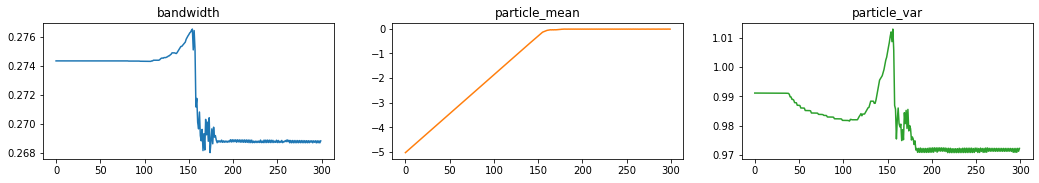

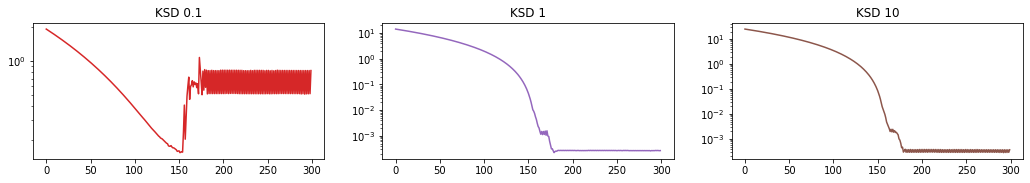

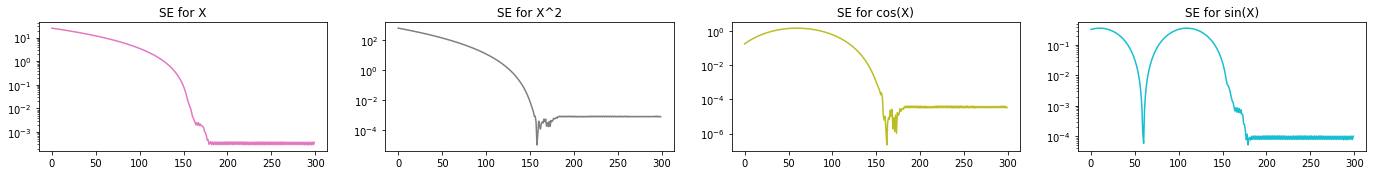

In [4]:
plot.svgd_log(log11, full=True)

In [5]:
dist11.compute_metrics(xout11, normalize=True)

{'square_errors': DeviceArray([[0.12103351],
              [0.21431379],
              [0.09802479],
              [0.09528989]], dtype=float32),
 'ksds': DeviceArray([2.5805566, 0.0659778, 0.1220862], dtype=float32)}

In [6]:
dist11.compute_metrics(xout11)

{'square_errors': DeviceArray([[2.8740612e-04],
              [8.2665862e-04],
              [4.0661336e-05],
              [7.7897777e-05]], dtype=float32),
 'ksds': DeviceArray([5.1423585e-01, 2.6791063e-04, 2.8969269e-04], dtype=float32)}

## Experiment 1.2: mixture, median trick
Target distribution:
$$ p(x) = 1/3 \mathcal N(-2, 1) + 2/3 \mathcal N(2, 1) $$
Initialization:
$$ q_0(x) = \mathcal N(-10, 1) $$
Kernel bandwidth:
$$ h = \text{med}^2 / \log n, $$
where med is the median of the $ n \choose 2$ pairwise distances between the points $x_1, \dots, x_n$. Important to note: the bandwidth here changes adaptively across iterations.

In [7]:
dist12 = metrics.GaussianMixture([-4, 4], [1, 1], [1/3, 2/3])
rkey = random.split(rkey)[0]

In [8]:
# experiment:
n = 100
d = 1
stepsize = 0.1
L = 500
svgd_adaptive12 = SVGD(dist12, n_iter_max=L, adaptive_kernel=True, particle_shape=(n, d), adagrad=False)

In [9]:
x0 = svgd_adaptive12.initialize(rkey)
xout12, log12 = svgd_adaptive12.svgd(x0, stepsize, bandwidth=1, n_iter=L)
xout12.block_until_ready()
print("Done.")

JIT COMPILING svgd...
...done compiling svgd after 1.089890480041504 seconds.
Done.


## Diagnostics

In [10]:
dist12.compute_metrics(xout12, normalize=True)

{'square_errors': DeviceArray([[1.9929546e+02],
              [7.3769866e-03],
              [9.1323573e-06],
              [8.5815460e+01]], dtype=float32),
 'ksds': DeviceArray([0.5560302 , 0.00551857, 0.01471816], dtype=float32)}

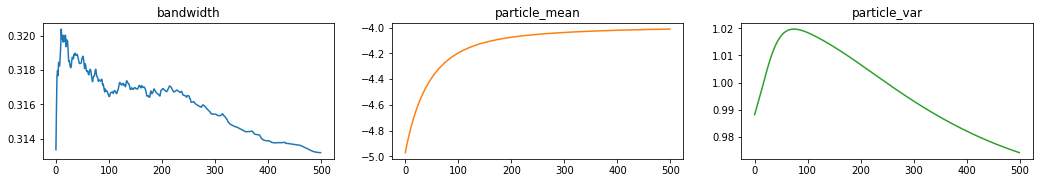

In [11]:
plot.svgd_log(log12)

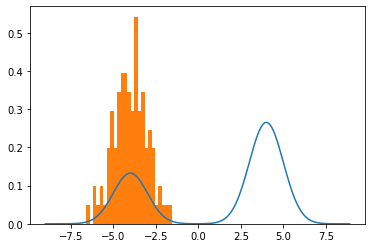

In [12]:
grid = np.arange(-9, 9, 0.1)

_ = plt.plot(grid, vmap(dist12.pdf)(grid))
_ = plt.hist(xout12[:, 0], density=True, bins=25)

Comparison to true random sample:

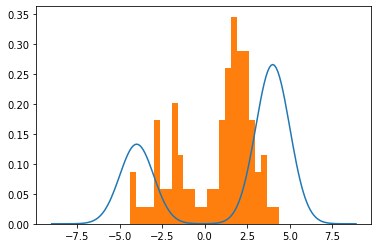

In [13]:
rkey = random.PRNGKey(0)
rkeys = random.split(rkey)
ntest = n
x1 = random.normal(rkeys[0], shape=(ntest // 3, 1)) - 2
x2 = random.normal(rkeys[1], shape=(ntest * 2 // 3, 1)) + 2
xtest = np.concatenate([x1, x2])

_ = plt.plot(grid, vmap(dist12.pdf)(grid))
_ = plt.hist(xtest[:, 0], density=True, bins=25)

## Experiment 1.3: fixed bandwidth
Again one dimension, but this time fix the bandwidth.

In [14]:
dist13 = metrics.GaussianMixture([-2, 2], [1, 1], [1/3, 2/3])
# dist13 = metrics.Gaussian(0, 1)
rkey = random.PRNGKey(10)

In [15]:
# experiment:
n = 100
d = 1
stepsize = 1
L = 1000

rkey = random.PRNGKey(0)

svgd_fix13 = SVGD(dist13, n_iter_max=L, particle_shape=(n, d))

In [16]:
h = 1
n_iter = L
x0 = svgd_fix13.initialize(rkey) * 5
st = time.time()
xout13, log13 = svgd_fix13.svgd(x0, stepsize, bandwidth=h, n_iter=n_iter)
xout13.block_until_ready()
end = time.time()
print(f"Done computing after {end - st} seconds.")

JIT COMPILING svgd...
...done compiling svgd after 0.8417518138885498 seconds.
Done computing after 8.82431697845459 seconds.


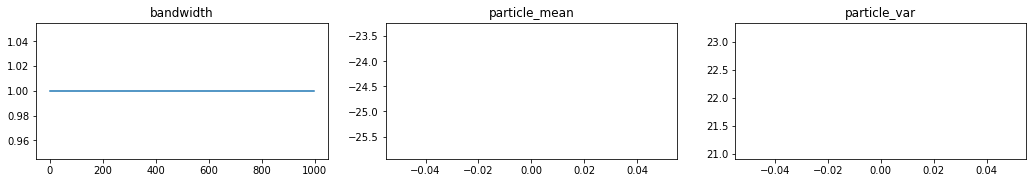

In [17]:
plot.svgd_log(log13)

In [18]:
dist13.compute_metrics(xout13)

{'square_errors': DeviceArray([[nan],
              [nan],
              [nan],
              [nan]], dtype=float32),
 'ksds': DeviceArray([nan, nan, nan], dtype=float32)}

/home/lauro/.virtualenvs/msc-thesis/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6619: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/home/lauro/.virtualenvs/msc-thesis/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6620: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: autodetected range of [nan, nan] is not finite

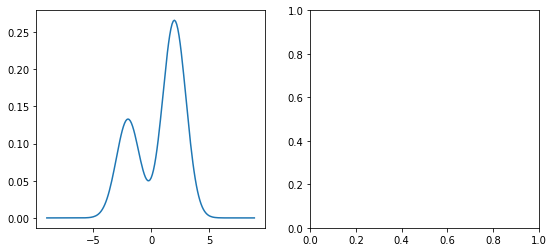

In [19]:
grid = np.arange(-9, 9, 0.1)
xtest = dist13.sample(shape=(n, 1))

fig, axs = plt.subplots(1, 2, figsize=[9, 4])
for ax, out in zip(axs, (xout13, xtest)):
    _ = ax.plot(grid, vmap(dist13.pdf)(grid))
    _ = ax.hist(out[:, 0], density=True, bins=25)

plot.equalize_axes(axs)

# Experiment 2: Multi-dim Gaussian

## Experiment 2.1
Same as before, only now $X$ is $d$-dimensional.
#### Target distribution:
$$ p(x) = \mathcal N(x; \mu, \Sigma), \ \ \ \text { where we take } \mu = (1, \dots, 1)^T \text{ and } \Sigma = I. $$
#### Initialization:
$$ q_0(x) = \mathcal N(x; \mu_0, \Sigma_0), \ \ \ \text{ with } \mu = (-10, \dots, -10) \text{ and } \Sigma = I. $$

#### Kernel:
We'll use a natural generalization of the RBF kernel: $k(x, y) = \exp(-\frac{1}{2} (x - y)^T \sigma^{-1} (x - y))$. The easiest way to adaptively choose the kernel is to let $\Sigma = \text{diag}(h_1, \dots, h_d)$ be diagonal, in which case the kernel is given by $k(x, y) = \exp(-\frac{1}{2} \sum_{k=1}^d \frac{(x_k - y_k)^2}{h_k})$. Then choose the bandwidth parameter
$$ h_k = \text{med}_k^2 / \log n, $$
where med$_k$ is the $k$-th entry in the ($d$-dimensional) median of the $ n \choose 2$ pairwise distances between the points $x_1, \dots, x_n$.

In [ ]:
mean21 = np.array([0, 0])
cov21 = np.array([[1, 0], [0, 1]])
# mean21 = np.array([0, 0, 5, -5, 3, -1])
# cov21 = np.array([1, 2, 5, 2, 1, 5])
dist21 = metrics.Gaussian(mean21, cov21)

In [ ]:
d = 2
stepsize = 1
L = 300
n = 100

svgd_adaptive21 = SVGD(dist21, n_iter_max=L, adaptive_kernel=True, particle_shape=(n, d), noise=1e-3)

In [ ]:
x0 = svgd_adaptive21.initialize(rkey)

xout21, log21 = svgd_adaptive21.svgd(x0, stepsize, bandwidth=0, n_iter=L)
xout21.block_until_ready()
print()

In [ ]:
plot.svgd_log(log21)

### Diagnostics

In [ ]:
dist21.compute_metrics(xout21, normalize=True)

In [ ]:
plot.bivariate_hist(xout21)

In [ ]:
plot.svgd_log(log21)

In [ ]:
rkey = random.PRNGKey(0)
xtest = random.multivariate_normal(rkey, mean21, cov21, shape=(n,))
plot.bivariate_hist(xtest)

Comparison histogram:

## Experiment 2.2:
Multivariate normal target function with non-diagonal covariance.

In [ ]:
mean22 = np.array([1,2])
cov22 = np.array([[1,1], [1, 2]])

dist22 = metrics.Gaussian(mean22, cov22)

In [ ]:
n = 100
d = 2
stepsize = 1
L = 300

svgd_adaptive22 = SVGD(dist22, n_iter_max=L, adaptive_kernel=True, particle_shape=(n, d))

In [ ]:
x0 = svgd_adaptive22.initialize(rkey)

xout22, log22 = svgd_adaptive22.svgd(x0, stepsize, bandwidth=0, n_iter=L)
xout22.block_until_ready()
print()

In [ ]:
plot.svgd_log(log22)

In [ ]:
dist22.compute_metrics(xout22, normalize=True)

In [ ]:
plot.bivariate_hist(xout22)

In [ ]:
xtest = dist22.sample(shape=(n,))
fig, axs = plt.subplots(1, 2, figsize = [10, 4.8])
for ax, out, title in zip(axs, (xout22, xtest), ("svgd", "true sample")):
    _ = ax.contour(*plot.make_meshgrid(dist22.pdf, [-2, 7]))
    _ = ax.scatter(*out.T)
    _ = ax.set_title(title)

In [ ]:
xtest = dist22.sample(shape=(n,))
fig, axs = plt.subplots(1, 2, figsize = [10, 4.8])

_ = axs[0].contour(*plot.make_meshgrid(dist22.pdf, [-2, 7]))
_ = axs[1].scatter(*out.T)
#     _ = ax.set_title(title)

Must be an issue with the plots??

#### Comparison histogram:

In [ ]:
rkey = random.PRNGKey(0)
xtest = random.multivariate_normal(rkey, mean22, cov22, shape=(10000,))

print("mean", np.mean(xtest, axis=0) - mean22)
print("var", np.var(xtest, axis=0) - cov22)

plot.bivariate_hist(xtest)

In [ ]:
dist22.compute_metrics(xtest)

## Experiment 2.3: fixed bandwidth

In [ ]:
mean = np.array([1, 2])
cov = np.array([[1,1], [1, 2]])
dist23 = metrics.Gaussian(mean, cov)

In [ ]:
n = 100
d = 2
stepsize = 1
L = 300

svgd_fix23 = SVGD(dist23, n_iter_max=L, particle_shape=(n, d))

In [ ]:
h = 1
x0 = svgd_fix23.initialize(rkey)

xout23, log23 = svgd_fix23.svgd(x0, stepsize, bandwidth=h, n_iter=L)
xout23.block_until_ready()
print()

In [ ]:
dist23.compute_metrics(xout23, normalize=True)

In [ ]:
plot.svgd_log(log23)

In [ ]:
plot.bivariate_hist(xout23)

Comparison histogram:

In [ ]:
rkey = random.PRNGKey(0)
xtest = random.multivariate_normal(rkey, mean, cov, shape=(100,))

plot.bivariate_hist(xtest)

## Experiment 2.4

In [ ]:
means = np.array([[0, 0], [-3, -2], [4, 4]])
covs = np.array([[2,2], [4, 3], [5, 4]])
weights = [1, 1, 1]
dist24 = metrics.GaussianMixture(means, covs, weights)
rkey = random.PRNGKey(0)

In [ ]:
s = dist24.sample(shape=(10**4,))
plot.bivariate_hist(s)

In [ ]:
n = 100
d = 2
stepsize = 1
L = int(10 / stepsize)
h = 1

svgd_fix24 = SVGD(dist24, n_iter_max=L, particle_shape=(n, d), adaptive_kernel=True, adagrad=True)

In [ ]:
h = 1
rkey = random.split(rkey)[0]
x0 = random.normal(rkey, shape=(n, d)) * 5 + np.array([dist24.mean])

xout24, log24 = svgd_fix24.svgd(x0, stepsize, bandwidth=h, n_iter=L)
xout24.block_until_ready()
print()

In [ ]:
dist24.compute_metrics(xout24, normalize=True)

In [ ]:
plt.figure(1)
plot.bivariate_hist(xout24)

In [ ]:
plt.figure(2)
ax = plot.plot_pdf(dist24.pdf, (-10, 23))

# Summary of Metrics

In [ ]:
ds = [dist11, dist12, dist13, dist21, dist22, dist23, dist24]
xs = [xout11, xout12, xout13, xout21, xout22, xout23, xout24]
labels = [11, 12, 13, 21, 22, 23, 24]

In [ ]:
key = "square_errors"
ind = 0
xpos = np.arange(len(ds)*2)
width=0.35
fig, ax = plt.subplots()
i = 0
for d, x in zip(ds, xs):
    data = d.compute_metrics(x, normalize=True)[key][ind]
    for dat in data:
#         print(dat)
        ax.bar(xpos[i], dat, width)
        i = i+1

# Experiment 3: Bayesian logistic regression

In [ ]:
# number of samples
n = 500

First, $\alpha \sim \text{Gamma}(a, b)$.

In [ ]:
from jax.scipy.stats import gamma

# Generate regression parameters
a = 2 # shape
# b = 1 # rate parameter (1 / scale)

key = random.PRNGKey(0)
gamma_samples = random.gamma(key, a, shape=(1000,))

count, bins, ignored = plt.hist(gamma_samples, bins = 100, density=True)
y = gamma.pdf(bins, a)
_ = plt.plot(bins, y, 'r')

In [ ]:
_ = plt.plot(bins, 1 / y)

In [ ]:
key = random.PRNGKey(0)
alpha = random.gamma(key, a, shape=(1,))

In [ ]:
print(alpha)

Now, $p(\beta \ \vert \alpha) = \mathcal N (\beta;\ 0, \alpha^{-1})$.

In [ ]:
beta = random.normal(key, shape=(2,)) * 1 / np.sqrt(alpha)

Finally, $\log \frac{\pi_i}{1 - \pi_i} = \beta_0 + \beta_1 X_i$. In other words,
$$ \pi_i = \frac{\text{exp}(\beta_0 + \beta_1 X_i)}{1 - \text{exp}(\beta_0 + \beta_1 X_i)}.$$

In [ ]:
x = np.linspace(start=-10, stop=10, num=n)
pi = np.exp(beta[0] + beta[1] * x / (1 - np.exp(beta[0] + beta[1] * x)))

We can now sample the $Y_i$, which are distributed as
$$Y_i \ \vert X_i \sim \text{Bernoulli}(\pi_i).$$

In [ ]:
y = random.bernoulli(key, p=pi, shape=(n,))

### Bayesian inference
We now have a set of observations $\{(y_i, x_i)\}_{i=1, \dots, n}$, (that is, `x` and `y`) and a prior $p(\beta_0, \beta_1)$ over the logistic regression parameters.

The prior is given as follows. Choose $\beta_0, \beta_1$ to be independently identically distributed as 
$$p(\beta) = p(\beta \vert \alpha) \ p(\alpha),$$
where 
\begin{align}   
    p(\beta \vert \alpha) &= \mathcal N(\beta; 0, \alpha^{-1}) \\
    p(\alpha) &= \text{Gamma}(\alpha; a, b),
\end{align}
and $a, b$ are fixed parameters.



Then the posterior is given by
\begin{equation}
    p(\beta_0, \beta_1 \vert x, y) \propto p(y \vert x; \beta_0, \beta_1) p(\beta_0, \beta_1).
\end{equation}

This posterior is the target distribution for SVGD.

In [ ]:
from jax.scipy.stats import norm, gamma

In [ ]:
def p(beta, alpha, x, y, a, b):
    """
    IN:
    * beta: np array w/ shape (2,), regression parameters
    * alpha: scalar > 0, precision parameter for beta prior
    * x: np array of shape (n,)
    * y: np array of shape (n,) and type bool (bernoulli sample)
    * a, b: scalars > 0, parameters for gamma prior on alpha
    
    OUT:
    * scalar, unnormalized posterior pdf evaluated at beta and alpha: p(beta, alpha | x, y, a, b)
    """
    assert beta.shape[0] == 2
    pi = np.exp(beta[0] + beta[1] * x) / (1 - np.exp(beta[0] + beta[1] * x))
    
    p1 = pi * y + (1 - pi) * (1 - y)
    p1 = np.prod(p1) # likelihood of all x's
    p2 = np.prod(norm.pdf(beta, loc=0, scale=1/alpha))
    p3 = gamma.pdf(alpha, a)
    
    return p1 * p2 * p3

In [ ]:
pb = vmap(p, in_axes=(0, None, None, None, None, None))
pbb = vmap(pb, in_axes=(0, None, None, None, None, None))

In [ ]:
def logp(beta, alpha, x, y, a, b):
    """
    IN:
    * beta: np array w/ shape (2,), regression parameters
    * alpha: scalar > 0, precision parameter for beta prior
    * x: np array of shape (n,)
    * y: np array of shape (n,) and type bool (bernoulli sample)
    * a, b: scalars > 0, parameters for gamma prior on alpha
    
    OUT:
    * scalar, unnormalized posterior pdf evaluated at beta and alpha: p(beta, alpha | x, y, a, b)
    """
    assert beta.shape[0] == 2
    
    log_pi = beta[0] + beta[1] * x - np.log(1 + np.exp(beta[0] + beta[1] * x)) # array of length n
    one_minus_log_pi = np.log(1 + np.exp(beta[0] + beta[1] * x)) # array of length n
    
    log_p1 = y * log_pi + (1 - y) * one_minus_log_pi # array of length n
    log_p1 = np.sum(log_p1) # scalar
    
    log_p2 = np.sum(norm.logpdf(beta, loc=0, scale=1/alpha))
    log_p3 = gamma.logpdf(alpha, a)
    
    return log_p1 + log_p2 + log_p3

In [ ]:
logpb = vmap(logp, in_axes=(0, None, None, None, None, None))
logpbb = vmap(logpb, in_axes=(0, None, None, None, None, None))

### quick 3d plot of beta

In [ ]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

In [ ]:
# make data
num = 60
X = np.linspace(-7, 7, num)
Y = np.linspace(-7, 7, num)
X, Y = np.meshgrid(X, Y) # both shape (40, 40)
bet = np.array(list(zip(X, Y))).reshape(num, num, 2)

b = np.array(1)
print(logpbb(bet, alpha, x, y, a, b).shape)

Z = logpbb(bet, alpha, x, y, a, b)
Z = np.squeeze(Z)

In [ ]:
1 / alpha

In [ ]:
# plot
fig = plt.figure()
ax = fig.gca(projection='3d')
plt.xlabel("beta_0")
plt.ylabel("beta_1")
ax.set_zlabel("p(beta_0, beta_1, alpha)")

surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)